**Import libraries**

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

# **Load Data and Plot Samples**

In [3]:
TRAIN_DIR = ('../input/facial-recognition-dataset/Training/Training/')
TEST_DIR = ('../input/facial-recognition-dataset/Testing/Testing/')

In [4]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
IMG_SIZE= (48, 48)

In [6]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [01:18<00:00, 13.09s/it]


28273 images loaded from ../input/facial-recognition-dataset/Training/Training/ directory.


In [7]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [8]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:17<00:00,  2.93s/it]

7067 images loaded from ../input/facial-recognition-dataset/Testing/Testing/ directory.


In [9]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

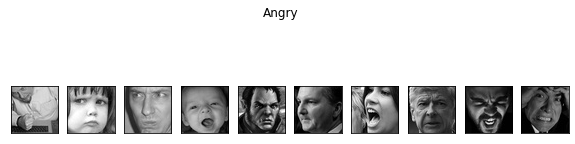

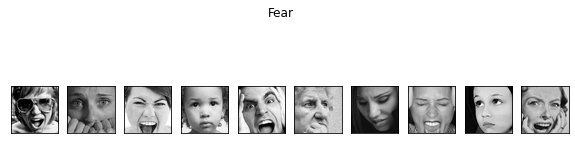

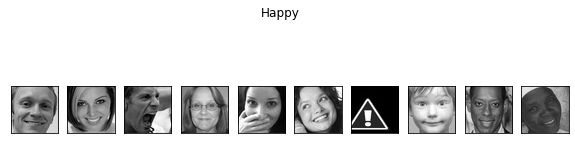

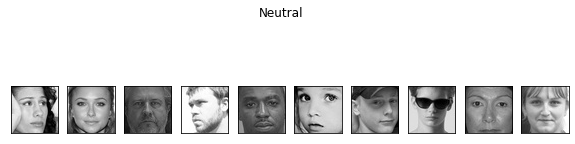

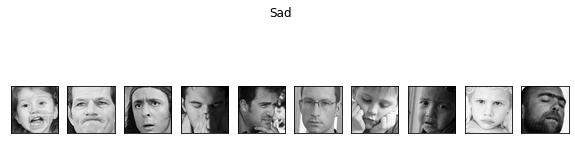

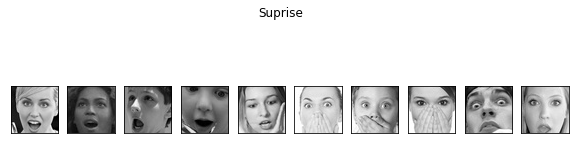

In [10]:
plot_samples(X_train, y_train, train_labels, 10)

In [11]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(28273, 6)

In [12]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

## Model without weights

In [13]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
    weights=None,  
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [14]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [15]:
def deep_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size):
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),  # Add validation data here
        verbose=1
    )
    return history


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()



In [17]:
history = deep_model(model, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=32)


Epoch 1/10
884/884 [==============================] - 31s 26ms/step - loss: 0.4643 - accuracy: 0.2387 - val_loss: 0.4447 - val_accuracy: 0.2510
Epoch 2/10
884/884 [==============================] - 22s 25ms/step - loss: 0.4237 - accuracy: 0.3004 - val_loss: 0.3677 - val_accuracy: 0.4241
Epoch 3/10
884/884 [==============================] - 22s 25ms/step - loss: 0.3518 - accuracy: 0.4646 - val_loss: 0.3330 - val_accuracy: 0.5016
Epoch 4/10
884/884 [==============================] - 22s 25ms/step - loss: 0.3204 - accuracy: 0.5242 - val_loss: 0.3083 - val_accuracy: 0.5452
Epoch 5/10
884/884 [==============================] - 22s 25ms/step - loss: 0.2962 - accuracy: 0.5704 - val_loss: 0.3012 - val_accuracy: 0.5609
Epoch 6/10
884/884 [==============================] - 22s 25ms/step - loss: 0.2770 - accuracy: 0.6039 - val_loss: 0.2934 - val_accuracy: 0.5698
Epoch 7/10
884/884 [==============================] - 22s 25ms/step - loss: 0.2556 - accuracy: 0.6500 - val_loss: 0.2859 - val_accuracy:

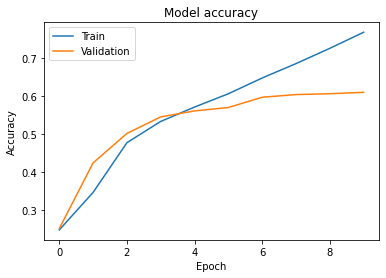

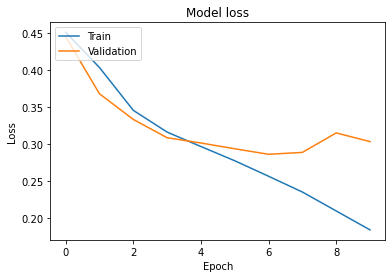

In [18]:
plot_metrics(history)



In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Test Accuracy = 0.61


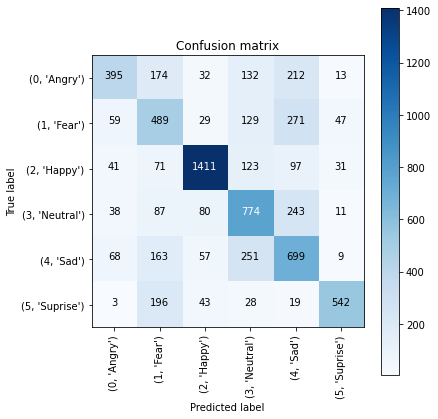

In [20]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

Test Loss: 0.30303582549095154
Test Accuracy: 0.6098768711090088


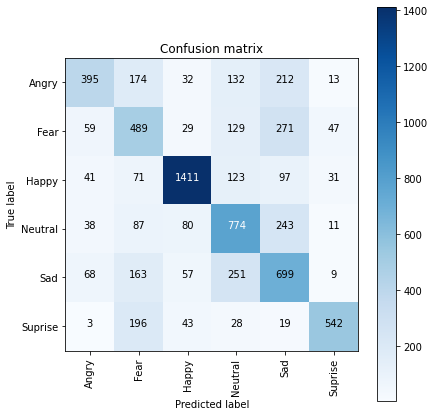

              precision    recall  f1-score   support

       Angry       0.65      0.41      0.51       958
        Fear       0.41      0.48      0.44      1024
       Happy       0.85      0.80      0.82      1774
     Neutral       0.54      0.63      0.58      1233
         Sad       0.45      0.56      0.50      1247
     Suprise       0.83      0.65      0.73       831

    accuracy                           0.61      7067
   macro avg       0.62      0.59      0.60      7067
weighted avg       0.63      0.61      0.62      7067



In [21]:
def evaluate_model(model, X_test, y_test, test_labels):
    # Evaluate on test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)

    # Confusion matrix
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plot_confusion_matrix(confusion_mtx, classes=list(test_labels.values()), normalize=False)

    # Classification report
    target_names = list(test_labels.values())
    print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

evaluate_model(model, X_test, Y_test, test_labels)



**Let's try our model and make predictions**

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = 30,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [23]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

In [24]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [25]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Happy,Angry
1,Angry/Angry-10.jpg,Sad,Angry
2,Angry/Angry-100.jpg,Sad,Angry
3,Angry/Angry-101.jpg,Fear,Angry
4,Angry/Angry-102.jpg,Sad,Angry


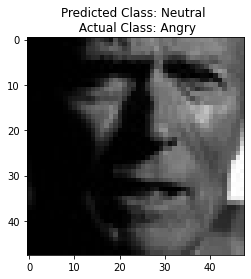

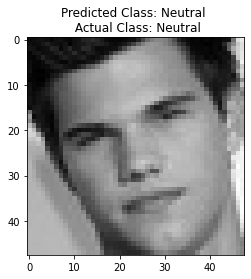

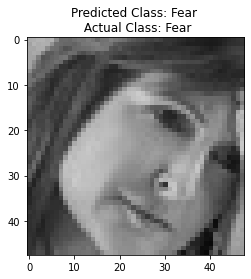

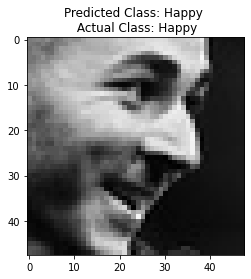

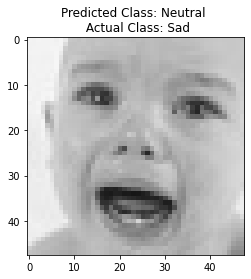

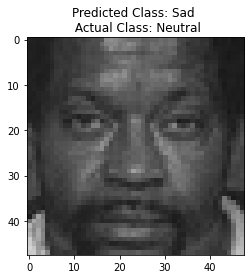

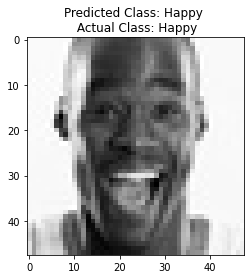

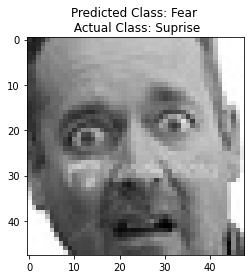

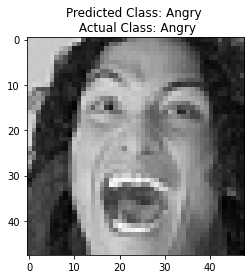

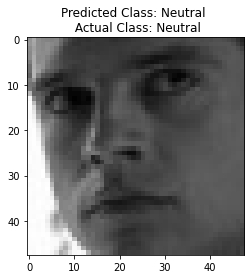

In [26]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass